In [65]:
import lightgbm as lgb
import pandas as pd 
import sqlite3
import numpy as np
from prophet import Prophet
from tqdm import tqdm
from sklearn.model_selection import KFold
from datetime import datetime as dt

In [66]:
pd.options.display.max_columns = 50

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    return conn

database = r"pythonsqlite.db"
conn = create_connection(database)

2.6.0


## Подготовка ежедневных данных для модели

In [69]:
query = '''
SELECT 
    PRICE_DATE, 
    d.FIGI,
    CLOSE_PRICE,
    OPEN_PRICE,
    HIGH_PRICE,
    LOW_PRICE,
    CURRENCY,
    NAME,
    TICKER,
    ISIN
FROM stocks_daily d
LEFT JOIN 
    stocks i ON i.FIGI = d.FIGI
'''
stocks_daily_df_1 = pd.read_sql(sql=query, con=conn)

query = ''' SELECT * FROM stocks_yahoo '''
stocks_yahoo_df_1 = pd.read_sql(sql=query, con=conn)

stocks_daily_df_1['PRICE_DATE'] = pd.to_datetime(stocks_daily_df_1['PRICE_DATE'])
stocks_daily_df_1.loc[:, 'WEEKDAY'] = stocks_daily_df_1.loc[:, 'PRICE_DATE'].dt.weekday
stocks_daily_df_1.loc[:, 'MONTH'] = stocks_daily_df_1.loc[:, 'PRICE_DATE'].dt.month
stocks_daily_df_1.loc[:, 'DAY'] = stocks_daily_df_1.loc[:, 'PRICE_DATE'].dt.day

stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.ME', '')
stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.DE', '@DE')

stocks_daily_df_1 = stocks_daily_df_1.merge(
    stocks_yahoo_df_1, how="inner", left_on="TICKER", right_on="SYMBOL"
)

stocks_daily_df_1 = stocks_daily_df_1[
    ~(
        (stocks_daily_df_1["MARKET"] == "us_market")
        & (stocks_daily_df_1["CURRENCY"] == "RUB")
    )
].reset_index(drop = True)

stocks_daily_df_1 = stocks_daily_df_1[stocks_daily_df_1["WEEKDAY"] != 5].reset_index(
    drop=True
)

val_counts_1 = stocks_daily_df_1['TICKER'].value_counts()
stocks_daily_df_1 = stocks_daily_df_1[stocks_daily_df_1['TICKER'].isin(val_counts_1[val_counts_1>100].index)].reset_index(drop = True)

stocks_daily_df_1['PRICE_DATE'] = stocks_daily_df_1['PRICE_DATE'].dt.date


<ipython-input-69-dc45053050b9>:27: FutureWarning: The default value of regex will change from True to False in a future version.
  stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.ME', '')
<ipython-input-69-dc45053050b9>:28: FutureWarning: The default value of regex will change from True to False in a future version.
  stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.DE', '@DE')


In [70]:

df_1 = stocks_daily_df_1.copy()
df_1.drop(
    columns=[
        "FIGI",
        "CURRENCY",
        "ISIN",
        "SYMBOL",
        "LONG_BUSINESS_SUMMARY",
        "CITY",
        "PRICE_HINT",
        "FORWARD_EPS",
        'MONTH',
        'NAME'
    ], inplace=True
)

### FBProphet

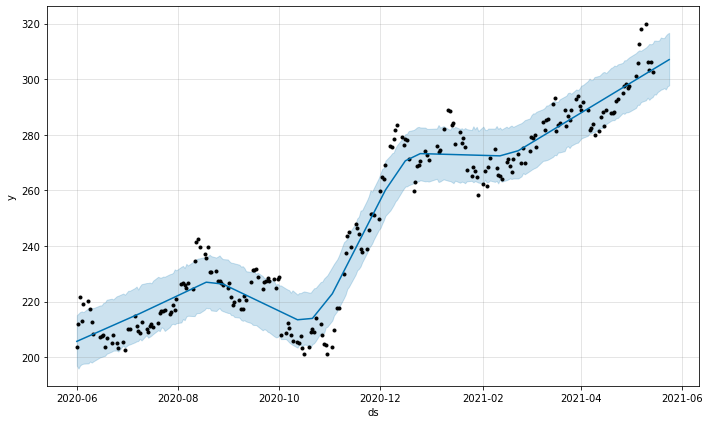

In [71]:
ticker = 'SBER'
buf_df = df_1[(df_1['TICKER']==ticker)][['PRICE_DATE','CLOSE_PRICE']]
buf_df.columns = ['ds', 'y']

m = Prophet(weekly_seasonality=False, yearly_seasonality=False, daily_seasonality=False)
# m.add_seasonality(name='weekly_custom', period=5, fourier_order=3)
m.fit(buf_df.iloc[:-10])
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)
fig1 = m.plot(forecast)


### LightGBM

In [72]:
target_comparsion = 'CLOSE_PRICE'
prices_columns = ["CLOSE_PRICE", "OPEN_PRICE", "HIGH_PRICE", "LOW_PRICE"]
df_1["CHANGE_1D_" + field] = (
        df_1[target_comparsion] / df_1.groupby("TICKER")["CLOSE_PRICE"].shift(1)
    )- 1
df_1["CHANGE_1W_" + field] = (
        df_1[target_comparsion] / df_1.groupby("TICKER")["CLOSE_PRICE"].shift(5)
    )- 1
df_1["CHANGE_1M_" + field] = (
        df_1[target_comparsion] / df_1.groupby("TICKER")["CLOSE_PRICE"].shift(20)
    )- 1
df_1['TARGET'] = (
    df_1.groupby("TICKER")["CLOSE_PRICE"].shift(-1)/df_1[target_comparsion]
) - 1
    # df_1[field] = df_1.groupby('TICKER')[field].shift(-1)

In [73]:
def groupby_func_1(x, cols):
    if x["PRICE_DATE"].nunique() == 1:
        date = x["PRICE_DATE"].unique()[0]
        z = df_1[
            (df_1["PRICE_DATE"] > x["PRICE_DATE"].unique()[0] - pd.Timedelta(10, "D"))&\
                 (df_1["PRICE_DATE"] <= x["PRICE_DATE"].unique()[0])
            ]
        for col in cols:
            if col == "PRICE_DATE":
                continue
            z = z[(z[col] == x[col].unique()[0])]
        return z[ "TARGET"].mean()
    else:
        return x["TARGET"].mean()


def add_agg(merged_df, gr_cols, new_col_name):

    agg1 = df_1.groupby(gr_cols).apply(groupby_func_1, gr_cols).reset_index()
    cols2 = gr_cols.copy()
    cols2.append(new_col_name)
    agg1.columns = cols2
    merged_df = pd.merge(df_1, agg1, how="left", left_on=gr_cols, right_on=gr_cols)
    return merged_df


In [43]:
df_2 = add_agg(df_1, ['PRICE_DATE', 'WEEKDAY','SECTOR', 'MARKET'], 'twsm')

In [59]:
train_target = df_2.loc[df_2['PRICE_DATE'] < dt.strptime('20210515' , '%Y%M%d').date()]['TARGET']
test_target = df_2.loc[df_2['PRICE_DATE'] >= dt.strptime('20210515' , '%Y%M%d').date()]['TARGET']
df_2.drop(columns = 'TARGET', inplace = True)

,PRICE_DATE,CLOSE_PRICE,OPEN_PRICE,HIGH_PRICE,LOW_PRICE,TICKER,WEEKDAY,DAY,SECTOR,INDUSTRY,MARKET,COUNTRY,FULL_TIME_EMPLOYEES,TRAILING_ANNUAL_DIVIDEND_YIELD,PAYOUT_RATIO,BETA,FORWARD_PE,ENTERPRISE_TO_EBITDA,BOOK_VALUE,NET_INCOME_TO_COMMON,ENTERPRISE_TO_REVENUE,PROFIT_MARGINS,PRICE_TO_BOOK,CHANGE_1D_LOW_PRICE,CHANGE_1W_LOW_PRICE,CHANGE_1M_LOW_PRICE,twsm
159,2021-01-15,74.39,73.98,74.79,73.50,AEE,4,15,Utilities,Utilities—Regulated Electric,us_market,United States,9183.0,0.023671,0.5714,0.261445,20.68238,13.489,35.286,871000000.0,6.029,0.15722,2.362127,0.005406,-0.008133,-0.046282,-0.006839
160,2021-01-19,72.99,74.47,75.20,72.81,AEE,1,19,Utilities,Utilities—Regulated Electric,us_market,United States,9183.0,0.023671,0.5714,0.261445,20.68238,13.489,35.286,871000000.0,6.029,0.15722,2.362127,-0.018820,-0.027319,-0.073025,0.005879
161,2021-01-20,72.54,73.01,73.99,71.88,AEE,2,20,Utilities,Utilities—Regulated Electric,us_market,United States,9183.0,0.023671,0.5714,0.261445,20.68238,13.489,35.286,871000000.0,6.029,0.15722,2.362127,-0.006165,-0.022899,-0.080142,-0.006787
162,2021-01-21,71.74,72.73,73.10,71.65,AEE,3,21,Utilities,Utilities—Regulated Electric,us_market,United States,9183.0,0.023671,0.5714,0.261445,20.68238,13.489,35.286,871000000.0,6.029,0.15722,2.362127,-0.011028,-0.049801,-0.069279,0.005075
163,2021-01-22,72.88,71.69,73.00,71.01,AEE,4,22,Utilities,Utilities—Regulated Electric,us_market,United States,9183.0,0.023671,0.5714,0.261445,20.68238,13.489,35.286,871000000.0,6.029,0.15722,2.362127,0.015891,-0.015002,-0.047943,0.002433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368995,2021-05-24,90.70,90.96,91.50,90.33,FLOT,0,24,Industrials,Marine Shipping,ru_market,Russia,NaN,0.000618,NaN,NaN,NaN,247.090,1.703,267336992.0,126.965,0.16178,54.856136,-0.001101,0.008114,0.013634,0.003018
368996,2021-05-25,90.86,90.99,91.12,90.27,FLOT,1,25,Industrials,Marine Shipping,ru_market,Russia,NaN,0.000618,NaN,NaN,NaN,247.090,1.703,267336992.0,126.965,0.16178,54.856136,0.001764,0.005756,0.015082,-0.009552
368997,2021-05-26,91.40,90.86,91.46,90.51,FLOT,2,26,Industrials,Marine Shipping,ru_market,Russia,NaN,0.000618,NaN,NaN,NaN,247.090,1.703,267336992.0,126.965,0.16178,54.856136,0.005943,0.023058,0.023746,0.000710
368998,2021-05-27,94.09,91.90,94.09,91.05,FLOT,3,27,Industrials,Marine Shipping,ru_market,Russia,NaN,0.000618,NaN,NaN,NaN,247.090,1.703,267336992.0,126.965,0.16178,54.856136,0.029431,0.054112,0.055176,-0.001624


In [61]:
params = {
    'nthread': 8,
    'max_depth': -1,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mse', 
    'num_leaves': 31,
    'learning_rate': 0.03,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.05,
    'lambda_l2': 0.05,
    'verbose': -1
}

In [ ]:
def train_lgbm(all_x, all_y, test_x):

    oof_preds = np.zeros([all_y.shape[0]])
    sub_preds = np.zeros([test_x.shape[0]])

    feature_importance_df  = pd.DataFrame()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state = 2021)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(all_x)):
        train_x, train_y = all_x[train_idx], all_y[train_idx]
        valid_x, valid_y = all_x[valid_idx], all_y[valid_idx]
        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_valid = lgb.Dataset(valid_x, valid_y)

        # train
        gbm = lgb.train(
            params,
            lgb_train,
            1000,
            valid_sets=[lgb_train, lgb_valid],
            early_stopping_rounds=100,
            verbose_eval=100,
        )
        oof_preds[valid_idx] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
        sub_preds[:] += (
            gbm.predict(test_x, num_iteration=gbm.best_iteration) / folds.n_splits
        )
        valid_idx += 1
        importance_df = pd.DataFrame()
        importance_df["feature"] = used_columns
        importance_df["importance"] = gbm.feature_importance()
        importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, importance_df], axis=0)
        return oof_preds, sub_preds, feature_importance_df

In [ ]:
num_folds = 5
test_x = df_2.loc[df_2['PRICE_DATE'] >= '20210515'].drop(columns = ['PRICE_DATE', 'INDUSTRY','COUNTRY','TICKER', 'WEEKDAY','SECTOR', 'MARKET']).values
all_x = df_2.loc[df_2['PRICE_DATE'] < '20210515'].drop(columns =['PRICE_DATE', 'INDUSTRY','COUNTRY','TICKER', 'WEEKDAY','SECTOR', 'MARKET']).values
all_y = train_target.values

used_columns = df_2.drop(columns = ['PRICE_DATE', 'INDUSTRY','COUNTRY','TICKER', 'WEEKDAY','SECTOR', 'MARKET']).columns

_, sub_preds, feature_importance_df = train_lgbm(all_x, all_y, test_x)

In [275]:
result = pd.concat([df_2.loc[df_2['PRICE_DATE'] >= '20210515'], test_target, pd.Series(sub_preds, index = test_target.index, name='PREDICT')],axis=1)

In [276]:
result['ERROR'] = result['PREDICT'] - result['TARGET'] 
result['ABSERROR'] = abs(result['TARGET'] - result['PREDICT'])

In [277]:
result.groupby('SECTOR')['ERROR'].agg(['mean','median', 'std', 'min', 'max', 'count']).sort_values('median')

,mean,median,std,min,max,count
SECTOR,,,,,,
Real Estate,-0.003870,-0.003816,0.012916,-0.064378,0.031211,540
Technology,-0.005394,-0.003790,0.018703,-0.166241,0.137995,2099
Healthcare,-0.003590,-0.001985,0.024708,-0.257608,0.383102,2103
Communication Services,-0.003147,-0.001582,0.020196,-0.090002,0.110209,812
Utilities,-0.001062,-0.000899,0.012517,-0.109312,0.040290,611
Industrials,-0.002412,-0.000855,0.018499,-0.291184,0.144908,1980
Financial Services,-0.000958,-0.000496,0.012345,-0.082827,0.045142,1321
Consumer Cyclical,-0.001919,-0.000431,0.023190,-0.182994,0.115960,1852
Consumer Defensive,-0.000630,-0.000391,0.018473,-0.185423,0.173007,845


In [248]:
result.groupby('MARKET')['ERROR'].agg(['mean','median', 'std', 'min', 'max', 'count']).sort_values('median')

,mean,median,std,min,max,count
MARKET,,,,,,
us_market,-0.002702,-0.001412,0.020391,-0.286709,0.379628,12300
ru_market,-0.001482,-0.000400,0.017265,-0.163916,0.081595,1259
de_market,0.001018,-0.000253,0.013307,-0.028689,0.050081,80


In [251]:
result.groupby('WEEKDAY')['ERROR'].agg(['mean','median', 'std', 'min', 'max', 'count']).sort_values('median')

,mean,median,std,min,max,count
WEEKDAY,,,,,,
1,-0.011300,-0.010117,0.022021,-0.264775,0.365285,3046
4,-0.007607,-0.005935,0.019402,-0.286709,0.186062,1526
2,-0.001755,-0.000238,0.020232,-0.149266,0.379628,3045
0,-0.000415,0.000439,0.017869,-0.161140,0.147488,3035
3,0.005809,0.004981,0.015624,-0.172356,0.101669,3045


## Подготовка почасовых данных для модели

In [17]:
query = '''
SELECT 
    PRICE_DATE, 
    h.FIGI,
    CLOSE_PRICE,
    OPEN_PRICE,
    HIGH_PRICE,
    LOW_PRICE,
    CURRENCY,
    NAME,
    TICKER,
    ISIN
FROM stocks_hourly h
LEFT JOIN 
    stocks i ON i.FIGI = h.FIGI
'''
stocks_hourly_df_1 = pd.read_sql(sql=query, con=conn)

stocks_hourly_df_1['PRICE_DATE'] = pd.to_datetime(stocks_hourly_df_1['PRICE_DATE'])
stocks_hourly_df_1.loc[:, 'WEEKDAY'] = stocks_hourly_df_1.loc[:, 'PRICE_DATE'].dt.weekday
stocks_hourly_df_1.loc[:, 'MONTH'] = stocks_hourly_df_1.loc[:, 'PRICE_DATE'].dt.month
stocks_hourly_df_1.loc[:, 'DAY'] = stocks_hourly_df_1.loc[:, 'PRICE_DATE'].dt.day
stocks_hourly_df_1.loc[:, 'HOUR'] = stocks_hourly_df_1.loc[:, 'PRICE_DATE'].dt.hour

stocks_hourly_df_1 = stocks_hourly_df_1.merge(
    stocks_yahoo_df_1, how="inner", left_on="TICKER", right_on="SYMBOL"
)

stocks_hourly_df_1 = stocks_hourly_df_1[
    ~(
        (stocks_hourly_df_1["MARKET"] == "us_market")
        & (stocks_hourly_df_1["CURRENCY"] == "RUB")
    )
].reset_index(drop = True)

stocks_hourly_df_1 = stocks_hourly_df_1[stocks_hourly_df_1["WEEKDAY"] != 5].reset_index(
    drop=True
)

val_counts_1 = stocks_hourly_df_1['TICKER'].value_counts()
stocks_hourly_df_1 = stocks_hourly_df_1[stocks_hourly_df_1['TICKER'].isin(val_counts_1[val_counts_1>1000].index)].reset_index(drop = True)


In [18]:
df_2 = stocks_hourly_df_1.copy()
df_2.drop(
    columns=[
        "FIGI",
        "CURRENCY",
        "ISIN",
        "SYMBOL",
        "LONG_BUSINESS_SUMMARY",
        "CITY",
        "PRICE_HINT",
        "FORWARD_EPS",
        'MONTH',
        'NAME'
    ], inplace=True
)

In [30]:
df_ru = df_2[df_2['MARKET'] == 'ru_market']

In [32]:
df_ru['PRICE_DATE'].dt.hour.unique()

array([ 8,  9, 11, 12, 13, 14, 15,  7, 10, 16, 17, 18, 19, 20])

In [37]:
target_comparsion = 'CLOSE_PRICE'
prices_columns = ["CLOSE_PRICE", "OPEN_PRICE", "HIGH_PRICE", "LOW_PRICE"]
for field in prices_columns:
    df_ru.loc[:,"CHANGE_1H_" + field] = (
            df_ru[target_comparsion] / df_ru.groupby("TICKER")["CLOSE_PRICE"].shift(1)
        )- 1

df_ru.loc[:, 'TARGET'] = (
        df_ru.groupby("TICKER")["CLOSE_PRICE"].shift(-1)/df_ru[target_comparsion]
    ) - 1

/mnt/d/Ubuntu/Sber/Project/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [38]:
def groupby_func_1(x, cols):
    if x["PRICE_DATE"].nunique() == 1:
        date = x["PRICE_DATE"].unique()[0]
        z = df_1[
            (df_1["PRICE_DATE"] > x["PRICE_DATE"].unique()[0] - pd.Timedelta(1, "W"))&\
                 (df_1["PRICE_DATE"] <= x["PRICE_DATE"].unique()[0])
            ]
        for col in cols:
            if col == "PRICE_DATE":
                continue
            z = z[(z[col] == x[col].unique()[0])]
        return z[ "TARGET"].mean()
    else:
        return x["TARGET"].mean()


def add_agg(merged_df, gr_cols, new_col_name):

    agg1 = df_ru.groupby(gr_cols).apply(groupby_func_1, gr_cols).reset_index()
    cols2 = gr_cols.copy()
    cols2.append(new_col_name)
    agg1.columns = cols2
    merged_df = pd.merge(df_ru, agg1, how="left", left_on=gr_cols, right_on=gr_cols)
    return merged_df


In [ ]:
df_2 = add_agg(df_1, ['WEEKDAY','HOUR', 'SECTOR'], 'twsm')